In [36]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling

In [37]:

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [53]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## FE

In [54]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [73]:

var_list = [f for f in train_df.columns if 'var' in f]
mean_var_list = [f+'_mean' for f in train_df.columns if 'var' in f]

# train_df['mean'] = np.mean(train_df[var_list],axis=1)
# train_df['std'] = np.std(train_df[var_list],axis=1)
# train_df['min'] = np.min(train_df[var_list],axis=1)
# train_df['max'] = np.max(train_df[var_list],axis=1)
# train_df['sum'] = np.sum(train_df[var_list],axis=1)
# train_df['median'] = np.median(train_df[var_list],axis=1)

train_df[mean_var_list] = train_df[var_list]/np.mean(train_df[var_list],axis=0)
test_df[mean_var_list] = test_df[var_list]/np.mean(test_df[var_list],axis=0)


In [74]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_median_mean,var_191_median_mean,var_192_median_mean,var_193_median_mean,var_194_median_mean,var_195_median_mean,var_196_median_mean,var_197_median_mean,var_198_median_mean,var_199_median_mean
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-0.675786,1.588773,-0.742493,0.737745,0.761862,-18.456953,1.905540,1.202815,0.974984,2.686008
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,3.328300,1.184578,0.488228,3.048812,0.865507,-3.571083,-0.648305,1.107599,1.205437,6.461426
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.234625,1.474001,1.028223,0.656228,0.721305,-15.922106,-3.102974,0.792354,1.253725,7.140160
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,3.000283,1.216985,0.860876,1.078050,0.843887,-23.684516,1.727139,1.035576,0.820256,1.297091
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,1.324831,1.229816,0.666426,1.016792,1.086528,2.139806,-2.252915,0.817757,0.877550,2.829215


## Model

In [75]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_folds = 5
random_seed = 26
model = 'lgb_mean_divide'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: lgb_mean_divide_5_folds


In [76]:
feats = train_df.iloc[:,2:].columns.tolist();feats


['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

Current Fold: 1
Training until validation scores don't improve for 50 rounds.
[500]	training's auc: 0.965782	valid_1's auc: 0.888033
Early stopping, best iteration is:
[690]	training's auc: 0.976701	valid_1's auc: 0.890145
AUC = 0.8901449438281481
getting feature importance
Current Fold: 2
Training until validation scores don't improve for 50 rounds.
[500]	training's auc: 0.966052	valid_1's auc: 0.886374
Early stopping, best iteration is:
[763]	training's auc: 0.980342	valid_1's auc: 0.888372
AUC = 0.888371965524646
getting feature importance
Current Fold: 3
Training until validation scores don't improve for 50 rounds.
[500]	training's auc: 0.965284	valid_1's auc: 0.892918
Early stopping, best iteration is:
[713]	training's auc: 0.977614	valid_1's auc: 0.894697
AUC = 0.8946967013183112
getting feature importance
Current Fold: 4
Training until validation scores don't improve for 50 rounds.
[500]	training's auc: 0.966009	valid_1's auc: 0.892227
Early stopping, best iteration is:
[735]	tr

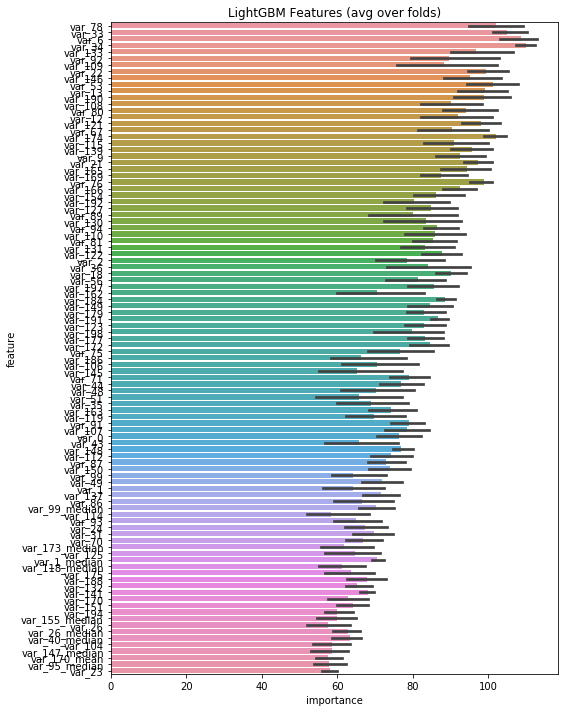

In [77]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))


X = train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 31, #31
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]


    trn_lgb = lgb.Dataset(trn_x, trn_y)
    val_lgb = lgb.Dataset(val_x, val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=3000,
                     early_stopping_rounds=50,
                     verbose_eval=500)
    


    val_pred = clf.predict(val_x)
    test_fold_pred = clf.predict(X_test)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
    print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)


In [80]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [79]:


shutil.copyfile(os.path.basename(NOTEBOOK_FULL_PATH), 
                             '../models/{}_{}.ipynb'.format(model_name, str(roc_score)))


'../models/lgb_mean_divide_5_folds_0.8920511611258052.ipynb'